P-Tuning是基于可训练参数的提示生成方法，通过在输入中插入一些可训练的Prompt嵌入，来增强模型对任务的适应能力。
- P-Tuning不直接调整文本输入，通过嵌入参数化的“提示序列”模型，更灵活适应。
- Prompt-Tuning是调整输入提示（Prompt）来引导模型跟准确理解任务。

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [77]:
# 定义P-Tuning模块
class PTuning(nn.Module):
    def __init__(self, prompt_length, embedding_size):
        super().__init__()
        self.prompt_embeddings = nn.Parameter(
            torch.normal(mean=0.0, std=0.02, size=(prompt_length, embedding_size))
        )
    
    def forward(self, embedding_input):
        N = embedding_input.size(0)
        prompt_embedding = self.prompt_embeddings.unsqueeze(0).expand(N, -1, -1)
        return torch.cat((prompt_embedding, embedding_input), dim=1)


In [78]:
# 加载BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('../bert-base-uncased')
bert = BertForSequenceClassification.from_pretrained('../bert-base-uncased', num_labels=2)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 468.98it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those

In [79]:
# 模拟数据加载
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    input_ids, attention_mask = encodings['input_ids'], encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

In [80]:
# 示例数据
texts = [
    'The model performs well with prompt tuning.',
    'Prompt-based learning enhances performance.',
]
labels = [1, 0]
dataset = prepare_data(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=2)

In [81]:
# 集成到BERT模型
class BertWithPTuning(nn.Module):
    def __init__(self, bert: BertForSequenceClassification, prompt_length: int=20):
        super().__init__()
        self.bert = bert
        for param in self.bert.parameters():
            param.requires_grad = False
        self.prompt_length = prompt_length
        self.p_tuning = PTuning(self.prompt_length, self.bert.config.hidden_size)

    def forward(self, input_ids, attention_mask):
        batch_size, _seq_len = input_ids.shape
        embeddings = self.bert.bert.embeddings
        embedded_input = embeddings.word_embeddings(input_ids)
        embedded_input = embeddings.LayerNorm(embedded_input)

        prompt = self.p_tuning.prompt_embeddings
        prompt = embeddings.LayerNorm(prompt)

        prompt = prompt.unsqueeze(0).expand(batch_size, -1, -1)
        embedded_input_with_prompt = torch.cat([prompt, embedded_input], dim=1)

        # 扩展注意力掩码以匹配Prompt长度
        prompt_mask = torch.ones(
            batch_size,
            self.prompt_length,
            device=attention_mask.device,
            dtype=attention_mask.dtype
        )

        extended_attention_mask = torch.cat(
            [prompt_mask, attention_mask], dim=1
        )
        
        token_type_ids = torch.zeros(
            extended_attention_mask.shape,
            dtype=torch.long,
            device=attention_mask.device
        )
        outputs = self.bert(
            inputs_embeds=embedded_input_with_prompt, 
            attention_mask=extended_attention_mask,
            token_type_ids=token_type_ids,
        )
        return outputs.logits

In [82]:
# 实例化训练组件
p_tuned_model = BertWithPTuning(bert=bert, prompt_length=16)
optimizer = optim.Adam([
    { 'params': p_tuned_model.p_tuning.parameters(), "lr": 1e-4 }
])
criterion = nn.CrossEntropyLoss()

In [83]:
# 训练过程
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p_tuned_model.to(device)

def train_one_epoch(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    for batch in dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        # 前向传播
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            p_tuned_model.p_tuning.parameters(),
            max_norm=1.0
        ) # 梯度裁剪
        optimizer.step()
        # 记录损失
        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

Epoch 1, Loss: 0.7378, Accuracy: 0.5000
Epoch 2, Loss: 0.6479, Accuracy: 1.0000
Epoch 3, Loss: 0.6726, Accuracy: 0.5000
Epoch 4, Loss: 0.7621, Accuracy: 0.5000
Epoch 5, Loss: 0.7281, Accuracy: 0.0000
Epoch 6, Loss: 0.6562, Accuracy: 1.0000
Epoch 7, Loss: 0.6954, Accuracy: 0.5000
Epoch 8, Loss: 0.7621, Accuracy: 0.0000
Epoch 9, Loss: 0.7099, Accuracy: 0.5000
Epoch 10, Loss: 0.7357, Accuracy: 0.0000
Epoch 11, Loss: 0.6723, Accuracy: 1.0000
Epoch 12, Loss: 0.6722, Accuracy: 0.5000
Epoch 13, Loss: 0.6681, Accuracy: 0.5000
Epoch 14, Loss: 0.6729, Accuracy: 1.0000
Epoch 15, Loss: 0.7820, Accuracy: 0.5000
Epoch 16, Loss: 0.7181, Accuracy: 0.5000
Epoch 17, Loss: 0.6918, Accuracy: 0.5000
Epoch 18, Loss: 0.6201, Accuracy: 1.0000
Epoch 19, Loss: 0.6855, Accuracy: 0.5000
Epoch 20, Loss: 0.6233, Accuracy: 1.0000
Epoch 21, Loss: 0.7098, Accuracy: 0.5000
Epoch 22, Loss: 0.6789, Accuracy: 0.5000
Epoch 23, Loss: 0.6602, Accuracy: 0.5000
Epoch 24, Loss: 0.6244, Accuracy: 0.5000
Epoch 25, Loss: 0.6952, A

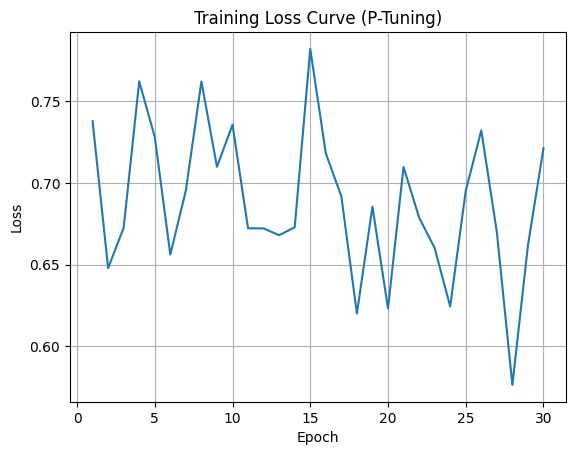

In [84]:
loss_history = []
for epoch in range(30):
    avg_loss, accuracy = train_one_epoch(dataloader, p_tuned_model, criterion, optimizer)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

def plot_loss_curve(loss_history):
    import matplotlib.pyplot as plt

    print("绘制训练损失曲线...", loss_history)
    plt.figure()
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve (P-Tuning)")
    plt.grid(True)
    plt.show()


plot_loss_curve(loss_history)